In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
from tensorflow import keras
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

2023-07-04 09:38:02.189973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 09:38:02.228967: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 09:38:02.229802: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 09:38:02.987625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Considering a Different Distritbution

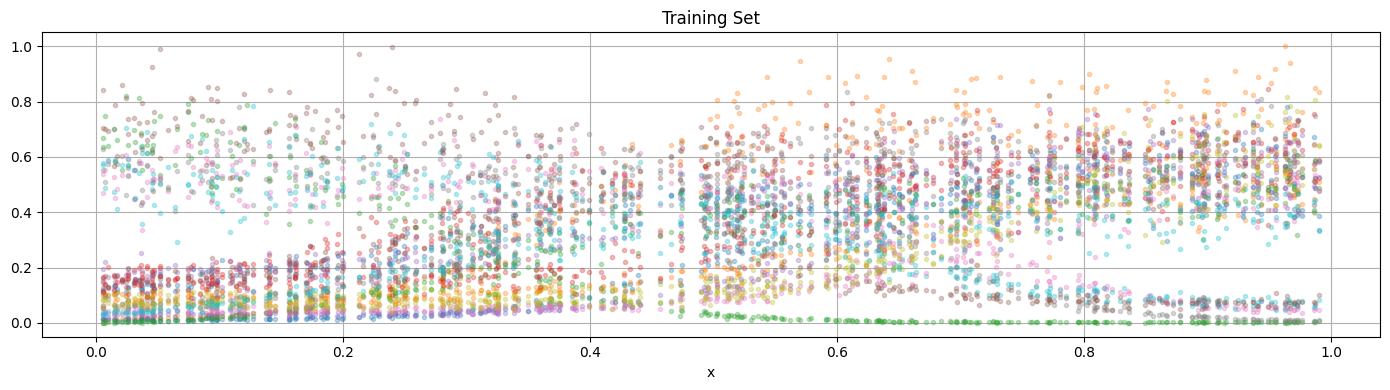

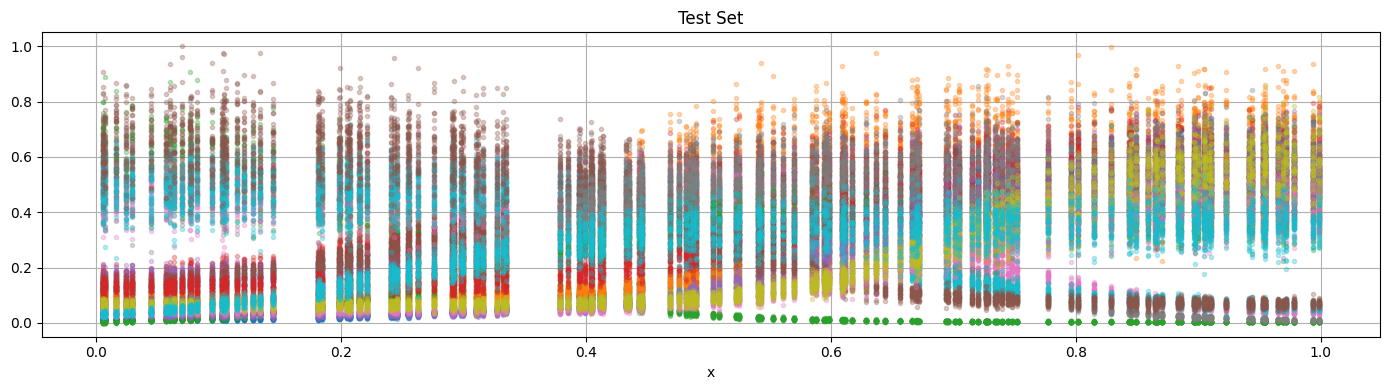

#Examples: 350 (training), 4500 (test)


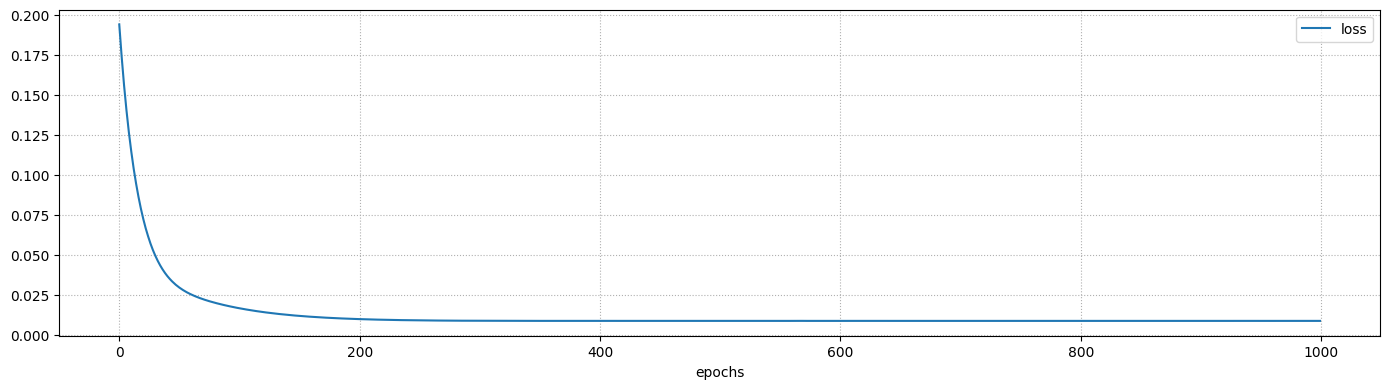

Final loss: 0.0086 (training)
R2: 0.79, MAE: 0.074, RMSE: 0.09 (training)
R2: 0.75, MAE: 0.075, RMSE: 0.09 (test)


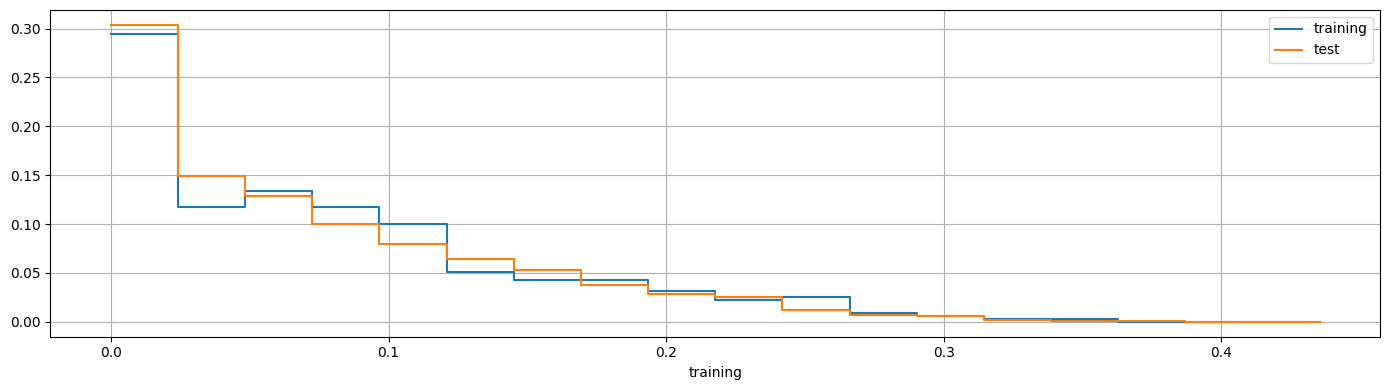

Mean: 0.080 (training), 0.075 (test)


In [23]:
nitems = 20
nsamples_tr = 350
nsamples_ts = 150
nsamples_per_point_tr = 1
nsamples_per_point_ts = 30
noise_scale = 0.15
noise_type = 'normal'
noise_scale_type = 'relative'
rel_req = 0.5

seed = 42

data_tr = util.generate_costs(nsamples_tr, nitems, seed=seed, sampling_seed=seed,
                              noise_scale=noise_scale, noise_type=noise_type, noise_scale_type=noise_scale_type,
                             nsamples_per_point=nsamples_per_point_tr)
data_ts = util.generate_costs(nsamples_ts, nitems, seed=seed, sampling_seed=seed+1,
                              noise_scale=noise_scale, noise_type=noise_type, noise_scale_type=noise_scale_type,
                             nsamples_per_point=nsamples_per_point_ts)

util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)
util.plot_df_cols(data_ts, figsize=figsize, title='Test Set', scatter=True)

print(f'#Examples: {len(data_tr)} (training), {len(data_ts)} (test)')

prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)


tr_in, tr_out = data_tr.index.values, data_tr.values
ts_in, ts_out = data_ts.index.values, data_ts.values

pfl = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='PFL', output_activation='linear')
history = util.train_nn_model(pfl, tr_in, tr_out, epochs=1000, loss='mse', validation_split=0)
util.plot_training_history(history, figsize=figsize)

r2, mae, rmse = util.get_ml_metrics(pfl, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(pfl, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

r_tr = util.compute_regret(prb, pfl, tr_in, tr_out)
r_ts = util.compute_regret(prb, pfl, ts_in, ts_out)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)

SPO, for the same problem

CPU times: user 3min 1s, sys: 12min 32s, total: 15min 34s
Wall time: 1min 32s


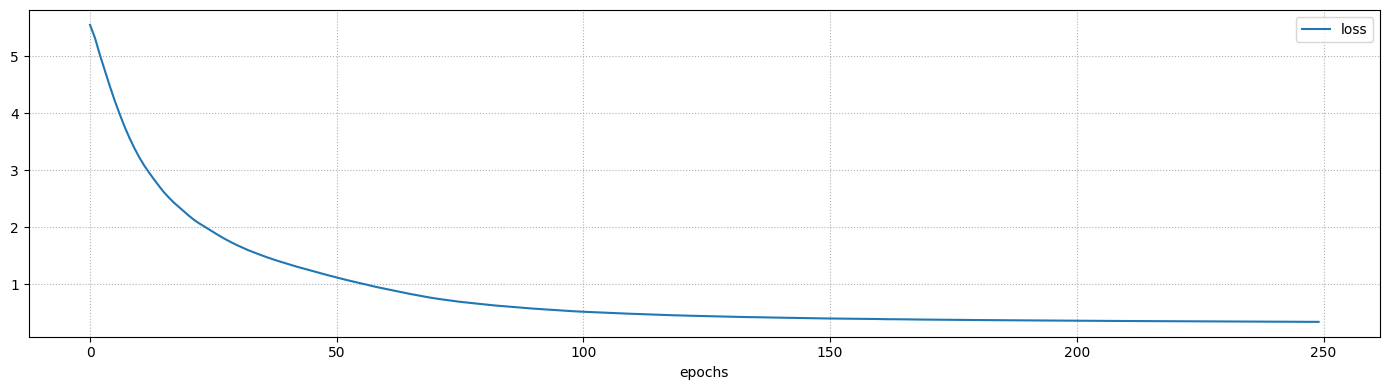

Final loss: 0.3374 (training)
R2: 0.21, MAE: 0.14, RMSE: 0.17 (training)
R2: 0.26, MAE: 0.12, RMSE: 0.16 (test)


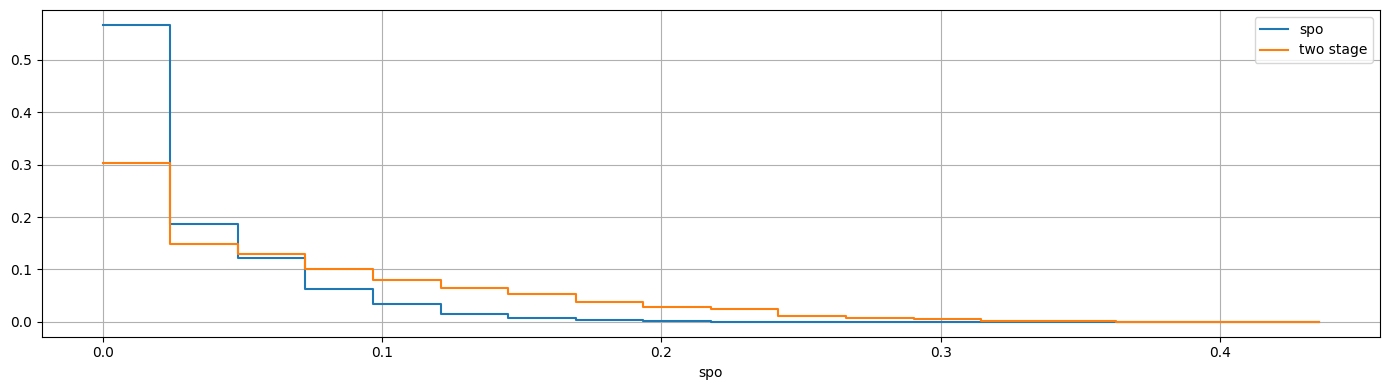

Mean: 0.030 (spo), 0.075 (two stage)


In [24]:
spo = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, recompute_chance=0.05,
                                   hidden=[], name='spo_cache', output_activation='linear',
                                  loss_type='spo')
%time history = util.train_dfl_model(spo, tr_in, tr_out, epochs=250, verbose=0, validation_split=0)
util.plot_training_history(history, figsize=figsize)

r2, mae, rmse = util.get_ml_metrics(spo, tr_in, tr_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (training)')
r2, mae, rmse = util.get_ml_metrics(spo, ts_in, ts_out)
print(f'R2: {r2:.2f}, MAE: {mae:.2}, RMSE: {rmse:.2f} (test)')

r_ts_spo = util.compute_regret(prb, spo, ts_in, ts_out)
util.plot_histogram(r_ts_spo, figsize=figsize, label='spo', data2=r_ts, label2='two stage', print_mean=True)